In [1]:
import numpy as np 
import pandas as pd 
import cv2
import tensorflow as tf
import os
import random
import sys
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import image
import skimage.io as io
import skimage.transform as trans
import matplotlib.image as mpimg
import scipy
import scipy.misc as sc
import sklearn.metrics as sm
import datetime
import IPython.display as display
import tensorflow_addons as tfa
import json
import math
import gc
import itertools

from glob import glob
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.utils.np_utils import to_categorical
from IPython.display import Image, display
from PIL import ImageOps
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm
from functools import partial
from sklearn import metrics
from collections import Counter
from PIL import Image

# dataset management

In [2]:
#detect reserved dataset path
path_benign_raw = "Dataset/benign/Original Image/"
path_benign_gt = "Dataset/benign/Segmentation Ground Truth/"
path_malignant_raw = "Dataset/malignant/Original Image/"
path_malignant_gt = "Dataset/malignant/Segmentation Ground Truth/"

In [3]:
#make folder if not exist
if not os.path.exists('SpeckleReduction'):
    os.makedirs('SpeckleReduction/benign')
    os.makedirs('SpeckleReduction/malignant')
if not os.path.exists('ContrastEnhancement'):
    os.makedirs('ContrastEnhancement/benign')
    os.makedirs('ContrastEnhancement/malignant')
if not os.path.exists('Binarization'):
    os.makedirs('Binarization/benign')
    os.makedirs('Binarization/malignant')
if not os.path.exists('SpeckleReduction'):
    os.makedirs('SpeckleReduction/benign')
    os.makedirs('SpeckleReduction/malignant')
if not os.path.exists('Revert'):
    os.makedirs('Revert/benign')
    os.makedirs('Revert/malignant')
if not os.path.exists('ReadyToGo'):
    os.makedirs('ReadyToGo/benign/Image')
    os.makedirs('ReadyToGo/benign/SegmentationGroundTruth') ##STILL EMPTY, GT dataset need to be copied from raw gt
    os.makedirs('ReadyToGo/malignant/Image')
    os.makedirs('ReadyToGo/malignant/SegmentationGroundTruth') ##STILL EMPTY, GT dataset need to be copied from raw gt
    os.makedirs('ReadyToGo/mix/Image')
    os.makedirs('ReadyToGo/mix/SegmentationGroundTruth') ##STILL EMPTY, GT dataset need to be copied from raw gt
if not os.path.exists('PredictedSegmentation'):
    os.makedirs('PredictedSegmentation/benign/Image')
    os.makedirs('PredictedSegmentation/malignant/Image')
    os.makedirs('PredictedSegmentation/mix/Image')

In [4]:
#detect target dataset path
path_benign_specreduc = "SpeckleReduction/benign/"
path_malignant_specreduc = "SpeckleReduction/malignant/"
path_benign_contench = "ContrastEnhancement/benign/"
path_malignant_contench = "ContrastEnhancement/malignant/"
path_benign_bin = "Binarization/benign/"
path_malignant_bin = "Binarization/malignant/"
path_benign_revert = "Revert/benign/"
path_malignant_revert = "Revert/malignant/"
path_benign_rtg = "ReadyToGo/benign/Image/"
path_malignant_rtg = "ReadyToGo/malignant/Image/"
path_benign_rtg_GT = "ReadyToGo/benign/SegmentationGroundTruth/"
path_malignant_rtg_GT = "ReadyToGo/malignant/SegmentationGroundTruth/"
path_benign_rtg2 = "ReadyToGo/benign/"
path_malignant_rtg2 = "ReadyToGo/malignant/"
path_rtgmix_images = "ReadyToGo/mix/Image/"
path_rtgmix_gt = "ReadyToGo/mix/SegmentationGroundTruth/"
path_rtgmix2 = "ReadyToGo/mix/"
path_predseg_benign = "PredictedSegmentation/benign/Image/"
path_predseg_malignant = "PredictedSegmentation/malignant/Image/"
path_predseg_mix = "PredictedSegmentation/mix/Image/"

# single run

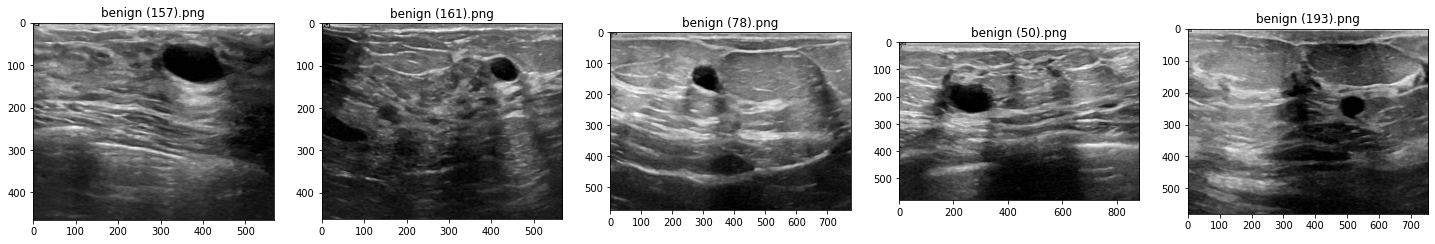

In [5]:
#FOR LATER
img_folder = path_benign_raw

plt.figure(figsize=(25,25))
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

## sample image check

In [6]:
image = cv2.imread("benign (10).png") #sample data
if(len(image.shape)<3):
      print ("gray")
elif len(image.shape)==3:
      print ("Color")
else:
      print ("others")

Color


In [7]:
image.shape

(585, 683, 3)

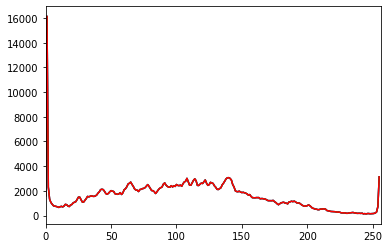

In [8]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([image],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

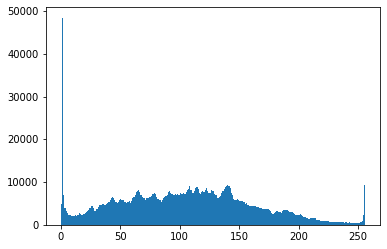

In [9]:
plt.hist(image.ravel(),256,[0,256]); plt.show()

## speckle reduction

### this is raw image

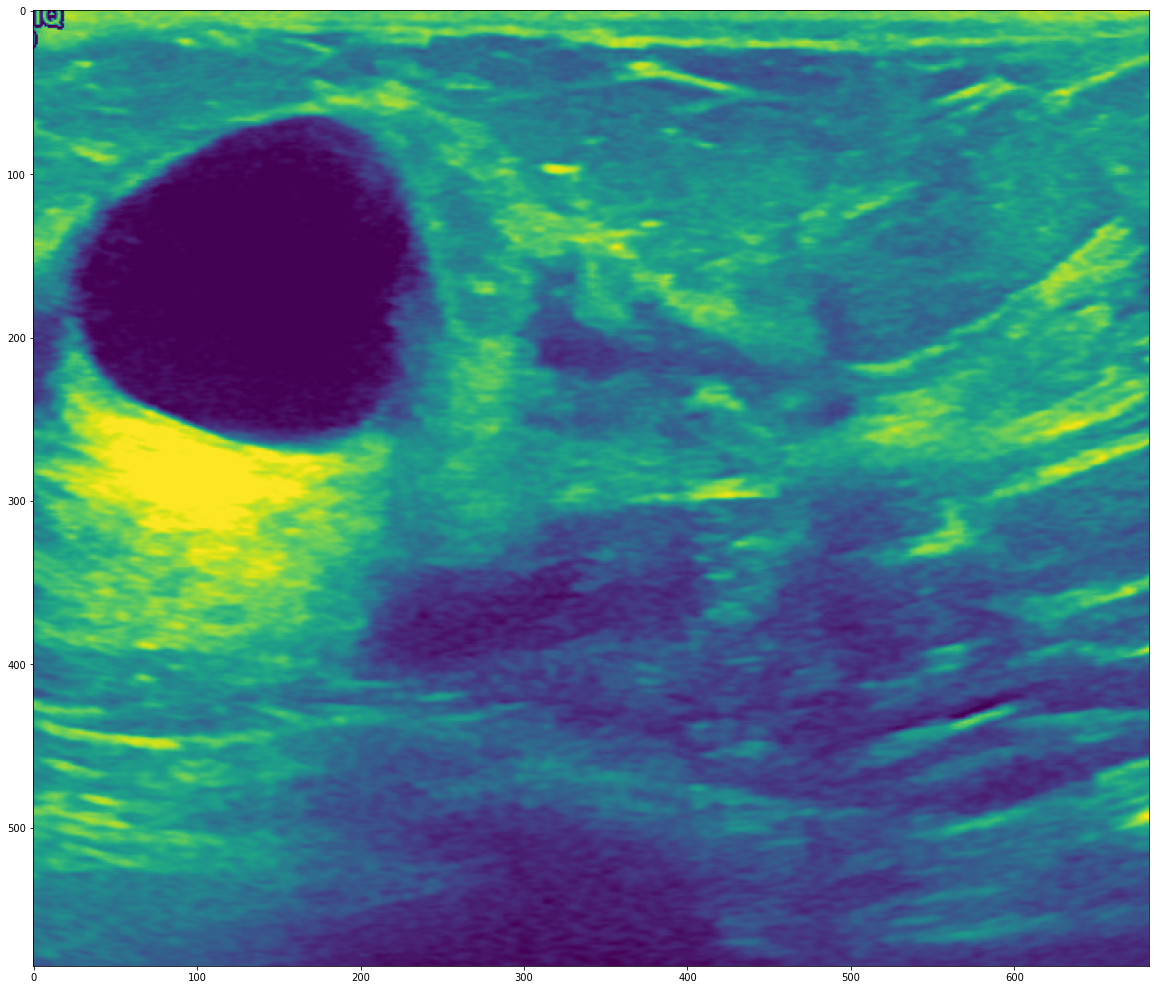

True

In [10]:
plt.figure(figsize=(20,20))

img = cv2.imread('benign (10).png')   #sample data
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

imgplot = plt.imshow(img)
plt.show(imgplot)
cv2.imwrite('raw.png', img)

In [11]:
img.shape

(585, 683)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-i1s8y2i1\opencv\modules\imgproc\src\histogram.cpp:160: error: (-215:Assertion failed) j < nimages in function 'cv::histPrepareImages'


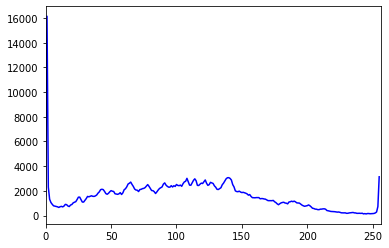

In [12]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

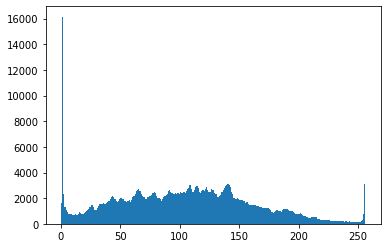

In [13]:
plt.hist(img.ravel(),256,[0,256]); plt.show()

#### bilateral filter d=tuneable (current=9)

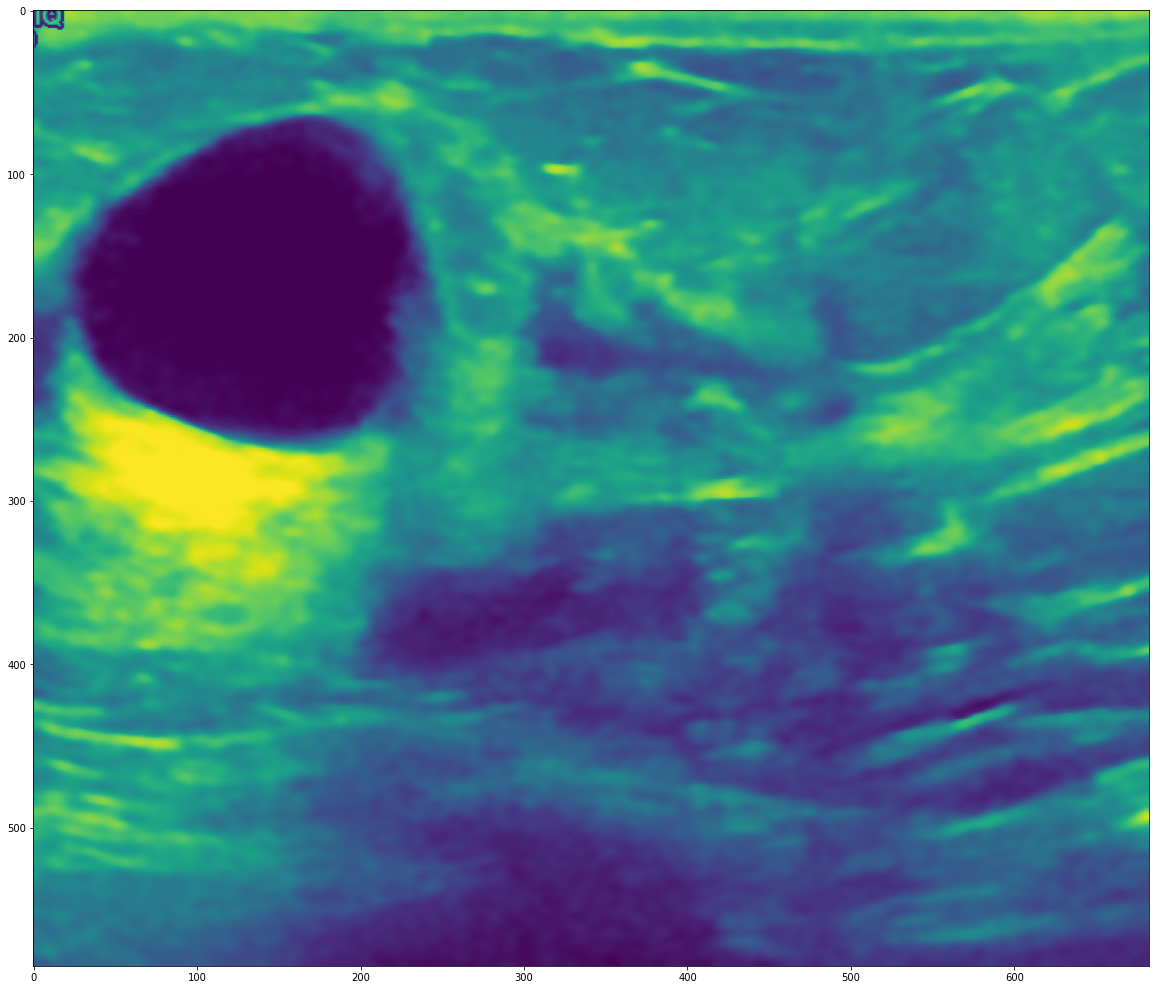

True

In [14]:
plt.figure(figsize=(20,20))

img = cv2.imread('benign (10).png')   #sample data
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

bilateralfilt = cv2.bilateralFilter(img,9,75,75)

bilateralres = plt.imshow(bilateralfilt)
plt.show(bilateralres)
cv2.imwrite('bilat25.png', bilateralfilt)

In [15]:
bilateralfilt.shape

(585, 683)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-i1s8y2i1\opencv\modules\imgproc\src\histogram.cpp:160: error: (-215:Assertion failed) j < nimages in function 'cv::histPrepareImages'


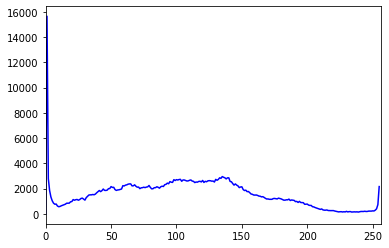

In [16]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([bilateralfilt],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

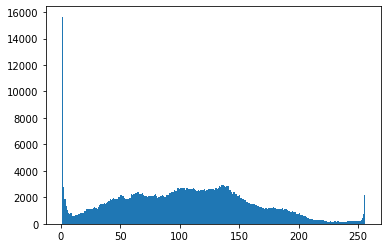

In [17]:
plt.hist(bilateralfilt.ravel(),256,[0,256]); plt.show()

## contrast enhancement

### equalizehist

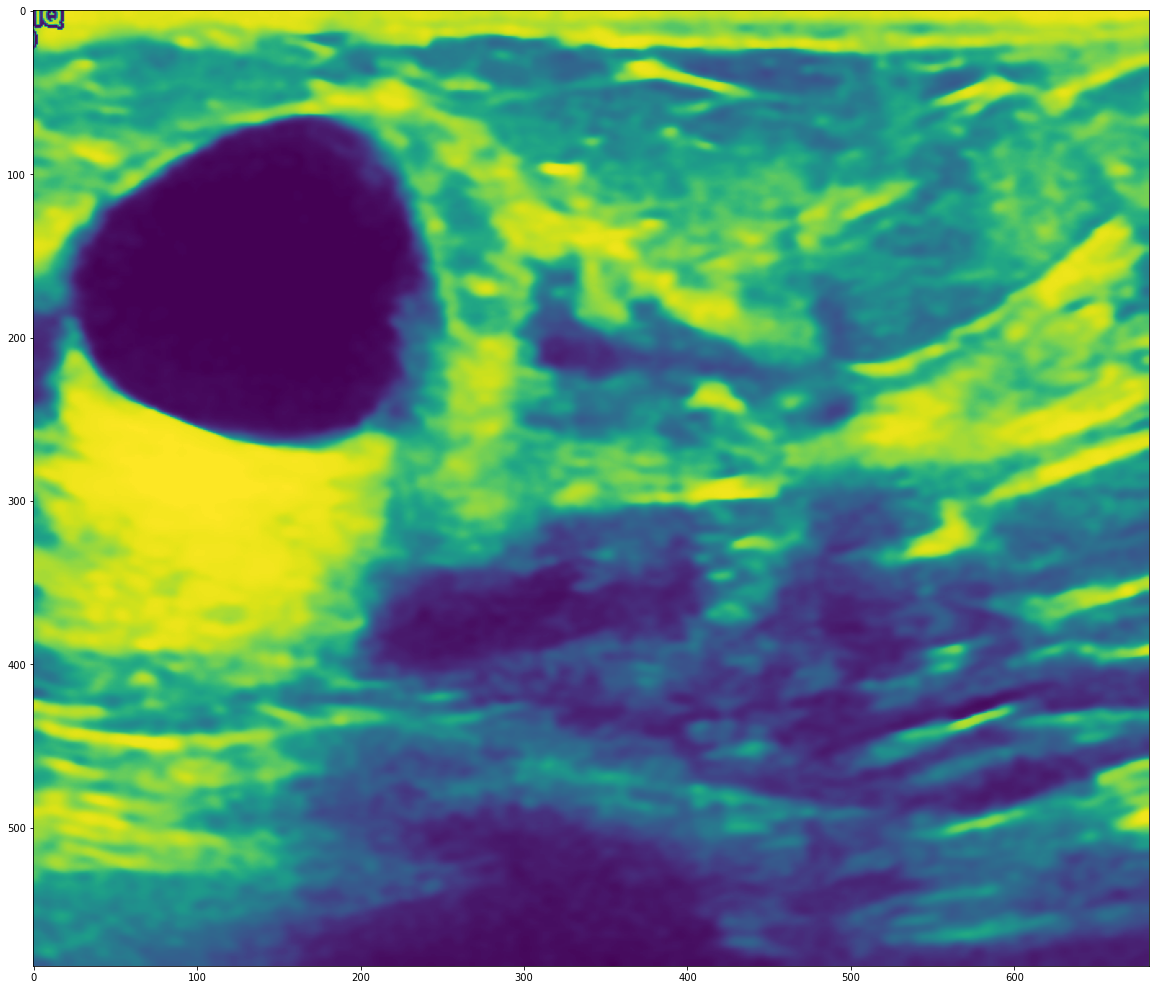

True

In [18]:
equ = cv2.equalizeHist(bilateralfilt)

plt.figure(figsize=(20,20))
ok = plt.imshow(equ)
plt.show(ok)
cv2.imwrite('enok.png', equ)

In [19]:
equ.shape

(585, 683)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-i1s8y2i1\opencv\modules\imgproc\src\histogram.cpp:160: error: (-215:Assertion failed) j < nimages in function 'cv::histPrepareImages'


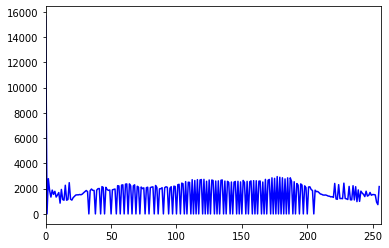

In [20]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([equ],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

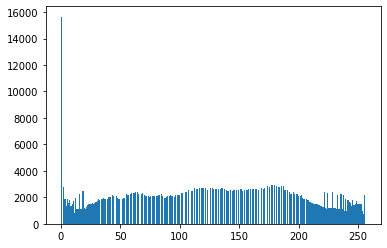

In [21]:
plt.hist(equ.ravel(),256,[0,256]); plt.show()

## binarization

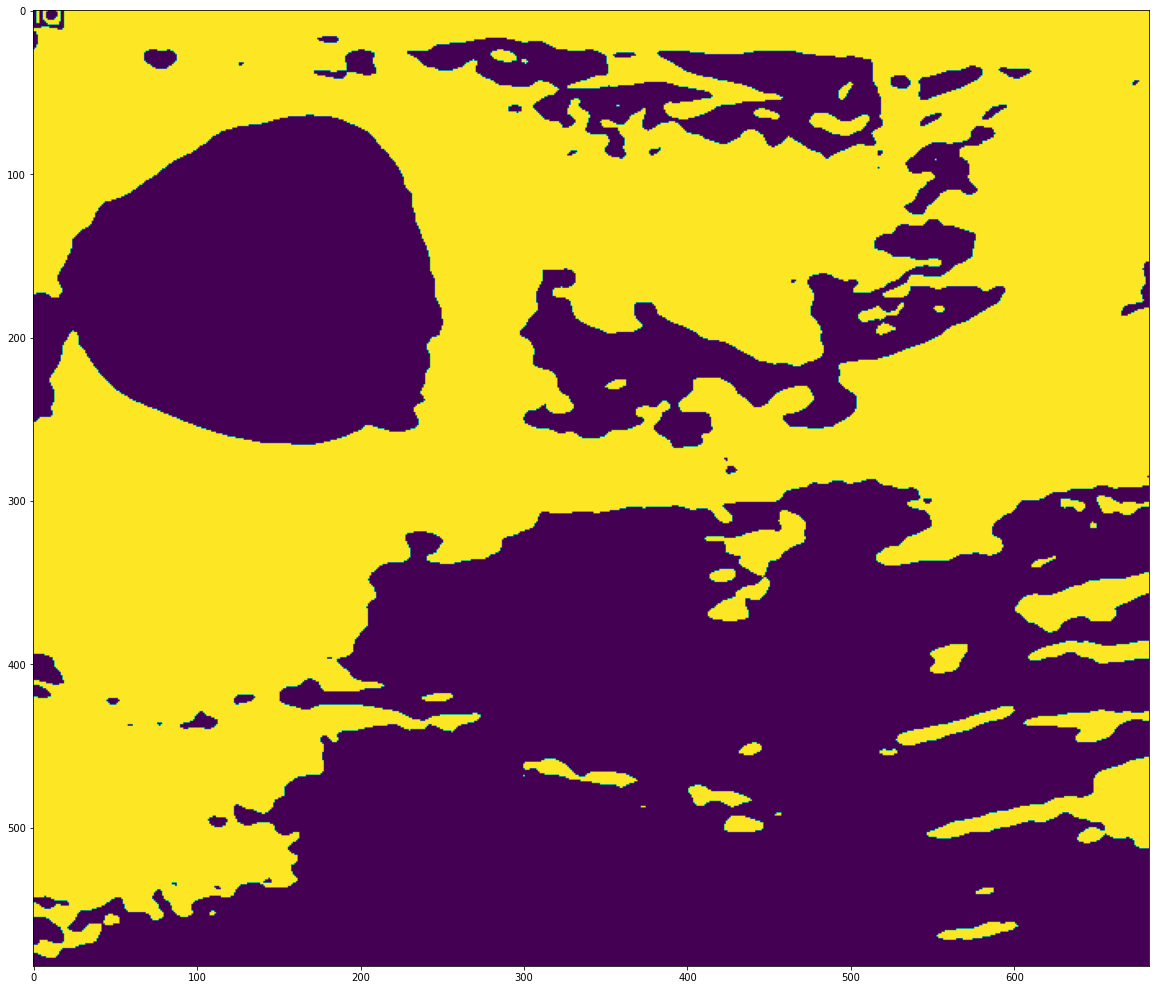

True

In [22]:
blur = cv2.GaussianBlur(equ,(5,5),0)
ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize=(20,20))
ok = plt.imshow(th)
plt.show(ok)
cv2.imwrite('bin.png', th)

In [23]:
th.shape

(585, 683)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-i1s8y2i1\opencv\modules\imgproc\src\histogram.cpp:160: error: (-215:Assertion failed) j < nimages in function 'cv::histPrepareImages'


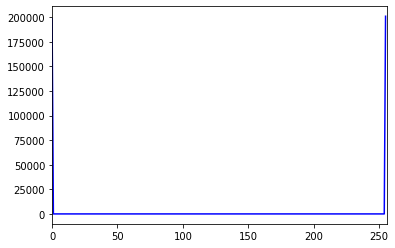

In [24]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([th],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

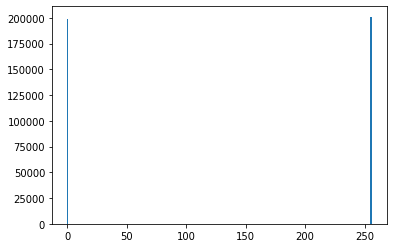

In [25]:
plt.hist(th.ravel(),256,[0,256]); plt.show()

## convert back to RGB form

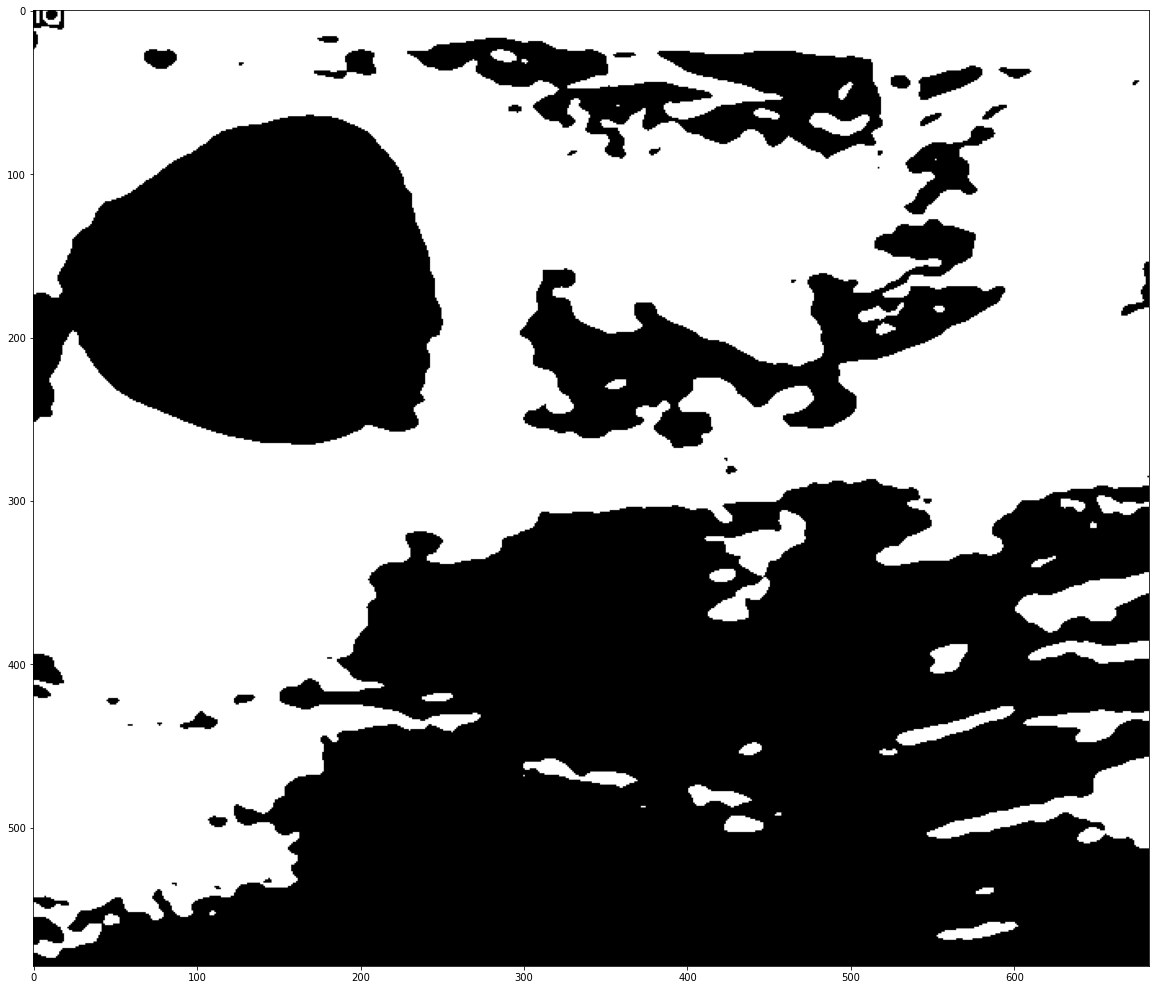

True

In [26]:
revert = cv2.cvtColor(th, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(20,20))
ok = plt.imshow(revert)
plt.show(ok)
cv2.imwrite('revert.png', revert)

In [27]:
revert.shape

(585, 683, 3)

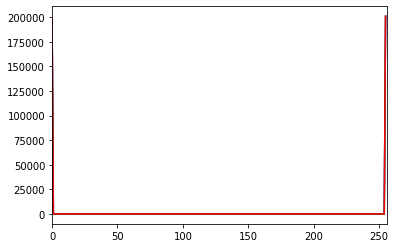

In [28]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([revert],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

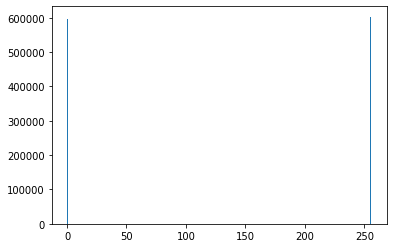

In [29]:
plt.hist(revert.ravel(),256,[0,256]); plt.show()

# all set batch steps run

## speckle reduction

### bilateral filter d=9

In [30]:
#bilateral filter all the image dataset
for filename in os.listdir(path_benign_raw):
    img = cv2.imread(os.path.join(path_benign_raw,filename))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    bilateralfilt = cv2.bilateralFilter(img,9,75,75)
    cv2.imwrite(os.path.join(path_benign_specreduc,filename), bilateralfilt)

for filename in os.listdir(path_malignant_raw):
    img = cv2.imread(os.path.join(path_malignant_raw,filename))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    bilateralfilt = cv2.bilateralFilter(img,9,75,75)
    cv2.imwrite(os.path.join(path_malignant_specreduc,filename), bilateralfilt)

## contrast enhancement

In [31]:
#equalizehist all the image dataset
for filename in os.listdir(path_benign_raw):
    img = cv2.imread(os.path.join(path_benign_raw,filename))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    bilateralfilt = cv2.bilateralFilter(img,9,75,75)
    equ = cv2.equalizeHist(bilateralfilt)
    cv2.imwrite(os.path.join(path_benign_contench,filename), equ)

for filename in os.listdir(path_malignant_raw):
    img = cv2.imread(os.path.join(path_malignant_raw,filename))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    bilateralfilt = cv2.bilateralFilter(img,9,75,75)
    equ = cv2.equalizeHist(bilateralfilt)
    cv2.imwrite(os.path.join(path_malignant_contench,filename), equ)

## binarization

In [32]:
#binarization all the image dataset
for filename in os.listdir(path_benign_raw):
    img = cv2.imread(os.path.join(path_benign_raw,filename))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    bilateralfilt = cv2.bilateralFilter(img,9,75,75)
    equ = cv2.equalizeHist(bilateralfilt)
    blur = cv2.GaussianBlur(equ,(5,5),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    cv2.imwrite(os.path.join(path_benign_bin,filename), th)

for filename in os.listdir(path_malignant_raw):
    img = cv2.imread(os.path.join(path_malignant_raw,filename))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    bilateralfilt = cv2.bilateralFilter(img,9,75,75)
    equ = cv2.equalizeHist(bilateralfilt)
    blur = cv2.GaussianBlur(equ,(5,5),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    cv2.imwrite(os.path.join(path_malignant_bin,filename), th)

## revert back to RGB mode

In [33]:
#reverting back to RGB all the image dataset
for filename in os.listdir(path_benign_raw):
    img = cv2.imread(os.path.join(path_benign_raw,filename))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    bilateralfilt = cv2.bilateralFilter(img,9,75,75)
    equ = cv2.equalizeHist(bilateralfilt)
    blur = cv2.GaussianBlur(equ,(5,5),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    revert = cv2.cvtColor(th, cv2.COLOR_GRAY2RGB)
    cv2.imwrite(os.path.join(path_benign_revert,filename), revert)

for filename in os.listdir(path_malignant_raw):
    img = cv2.imread(os.path.join(path_malignant_raw,filename))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    bilateralfilt = cv2.bilateralFilter(img,9,75,75)
    equ = cv2.equalizeHist(bilateralfilt)
    blur = cv2.GaussianBlur(equ,(5,5),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    revert = cv2.cvtColor(th, cv2.COLOR_GRAY2RGB)
    cv2.imwrite(os.path.join(path_malignant_revert,filename), revert)

# segmentation

In [34]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [35]:
!nvidia-smi

Thu Jun 24 21:31:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.63       Driver Version: 466.63       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P8     4W /  N/A |    537MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## dataset check

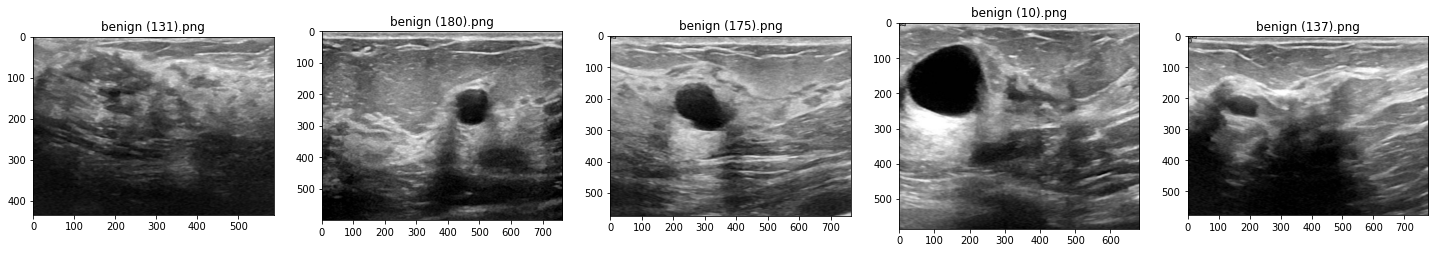

In [36]:
img_folder = path_benign_raw

plt.figure(figsize=(25,25))
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

## dataset preprocess

#### want to have a go with un-binarization image?
#### 1. comment blur and ret,th line
#### 2. change th to equ in revert line for cvtColor

#### want to change back to binarization image?
#### 1. uncomment blur and ret,th line
#### 2. change equ to th in revert line for cvtColor

In [37]:
##SEPARATE
#preprocess all the image dataset to different folder
for filename in os.listdir(path_benign_raw):
    img = cv2.imread(os.path.join(path_benign_raw,filename))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    bilateralfilt = cv2.bilateralFilter(img,9,75,75)
    equ = cv2.equalizeHist(bilateralfilt)
    #blur = cv2.GaussianBlur(equ,(5,5),0)
    #ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    revert = cv2.cvtColor(equ, cv2.COLOR_GRAY2RGB)
    cv2.imwrite(os.path.join(path_benign_rtg,filename), revert)

for filename in os.listdir(path_malignant_raw):
    img = cv2.imread(os.path.join(path_malignant_raw,filename))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    bilateralfilt = cv2.bilateralFilter(img,9,75,75)
    equ = cv2.equalizeHist(bilateralfilt)
    #blur = cv2.GaussianBlur(equ,(5,5),0)
    #ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    revert = cv2.cvtColor(equ, cv2.COLOR_GRAY2RGB)
    cv2.imwrite(os.path.join(path_malignant_rtg,filename), revert)

In [38]:
#MIX
#preprocess all the image dataset to same folder
for filename in os.listdir(path_benign_raw):
    img = cv2.imread(os.path.join(path_benign_raw,filename))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    bilateralfilt = cv2.bilateralFilter(img,9,75,75)
    equ = cv2.equalizeHist(bilateralfilt)
    #blur = cv2.GaussianBlur(equ,(5,5),0)
    #ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    revert = cv2.cvtColor(equ, cv2.COLOR_GRAY2RGB)
    cv2.imwrite(os.path.join(path_rtgmix_images,filename), revert)

for filename in os.listdir(path_malignant_raw):
    img = cv2.imread(os.path.join(path_malignant_raw,filename))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    bilateralfilt = cv2.bilateralFilter(img,9,75,75)
    equ = cv2.equalizeHist(bilateralfilt)
    #blur = cv2.GaussianBlur(equ,(5,5),0)
    #ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    revert = cv2.cvtColor(equ, cv2.COLOR_GRAY2RGB)
    cv2.imwrite(os.path.join(path_rtgmix_images,filename), revert)

## segmentation

### data loader

In [39]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

## dataset loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

In [40]:
# loading benign samples

framObjTrain = LoadData( framObjTrain, imgPath = path_benign_rtg    #change the imgPath to another source to change the path
                        , maskPath = path_benign_rtg_GT
                         , shape = 256)

In [41]:
# loading malignant samples

framObjTrain = LoadData( framObjTrain, imgPath = path_malignant_rtg    #change the imgPath to another source to change the path
                        , maskPath = path_malignant_rtg_GT
                         , shape = 256)

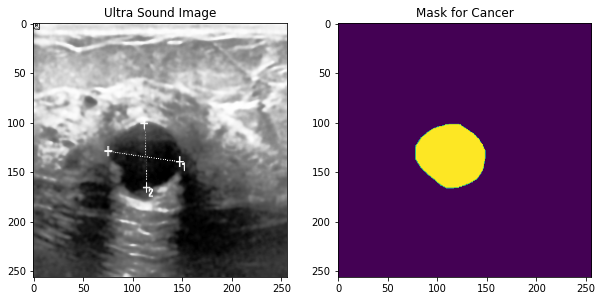

In [42]:
## displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.title('Mask for Cancer')
plt.show()

### model definition

In [43]:

# this block performs 2 convolution essentially

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def Unet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

### model instantiation

In [44]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = Unet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [45]:
myTransformer.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### training for x epochs

#### run both and result will appear to tell that the training process is done (still haven't got the way to display the progress and estimation)

In [46]:
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 100, verbose = 0)

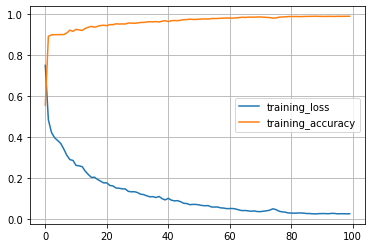

In [47]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

### testing

In [48]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

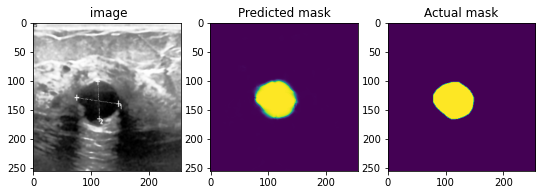

In [49]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, myTransformer)
Plotter(actuals[1], sixteenPrediction[1][:,:,0], masks[1])

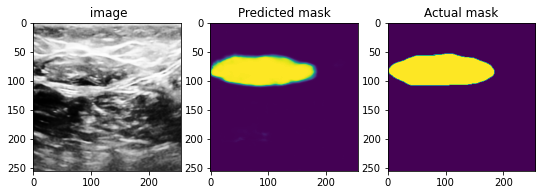

In [50]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

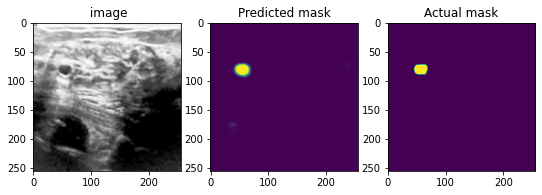

In [51]:
Plotter(actuals[3], sixteenPrediction[3][:,:,0], masks[3])

### saving model

In [52]:
myTransformer.save('BreastCancerSegmentation.h5')

# classification

## loading and preprocess

In [53]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

#CHANGE THESE 4 PATH INTO DESIRED ITEM (path_name)
benign_train = np.array(Dataset_loader(path_benign_raw,224))
malign_train = np.array(Dataset_loader(path_malignant_raw,224))
benign_test = np.array(Dataset_loader(path_benign_rtg,224))
malign_test = np.array(Dataset_loader(path_malignant_rtg,224))

100%|██████████| 205/205 [00:01<00:00, 163.00it/s]


## create label

In [54]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

## train and evaluation split

In [55]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

## check images

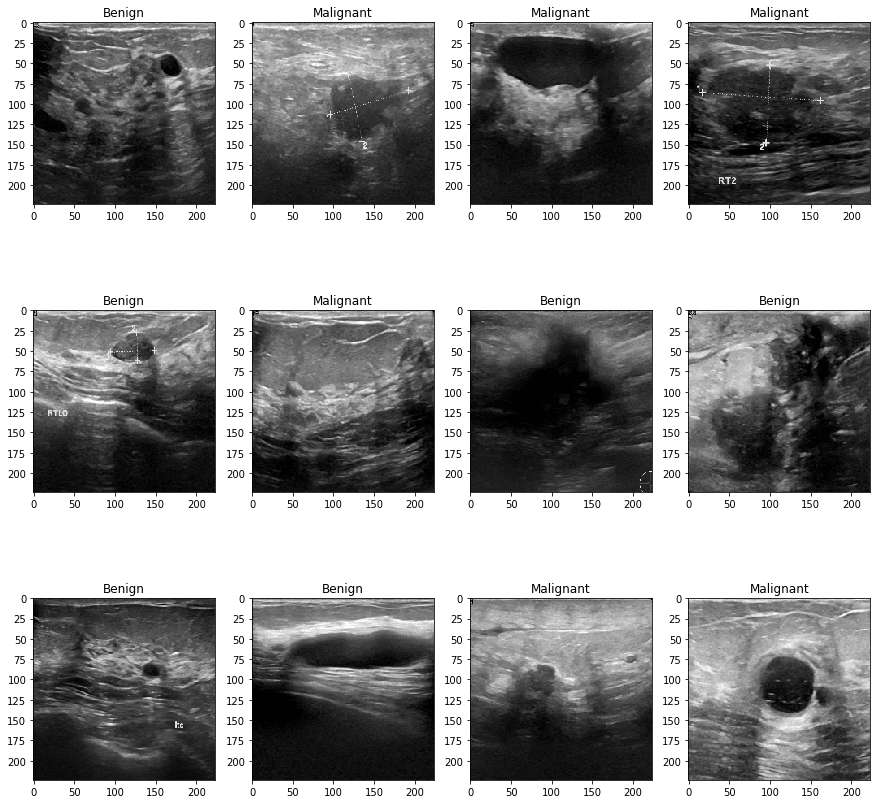

In [56]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

## data generator

In [57]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

## model DenseNet201

In [58]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [59]:
keras.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


In [60]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

## training and evaluation

In [61]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

C:\Users\joych\anaconda3\envs\image\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
20/20 [==============================] - 46s 986ms/step - loss: 0.8255 - accuracy: 0.4861 - val_loss: 0.5449 - val_accuracy: 0.7927

Epoch 00001: val_accuracy improved from -inf to 0.79268, saving model to weights.best.hdf5
Epoch 2/100
20/20 [==============================] - 7s 323ms/step - loss: 0.7545 - accuracy: 0.5618 - val_loss: 0.3703 - val_accuracy: 0.8537

Epoch 00002: val_accuracy improved from 0.79268 to 0.85366, saving model to weights.best.hdf5
Epoch 3/100
20/20 [==============================] - 7s 324ms/step - loss: 0.6143 - accuracy: 0.6709 - val_loss: 0.3761 - val_accuracy: 0.8171

Epoch 00003: val_accuracy did not improve from 0.85366
Epoch 4/100
20/20 [==============================] - 7s 316ms/step - loss: 0.6037 - accuracy: 0.7341 - val_loss: 0.2758 - val_accuracy: 0.8902

Epoch 00004: val_accuracy improved from 0.85366 to 0.89024, saving model to weights.best.hdf5
Epoch 5/100
20/20 [==============================] - 7s 316ms/step - loss: 0.5094 - accur

20/20 [==============================] - 7s 319ms/step - loss: 0.3191 - accuracy: 0.8652 - val_loss: 0.1767 - val_accuracy: 0.9268

Epoch 00039: val_accuracy did not improve from 0.96341
Epoch 40/100
20/20 [==============================] - 7s 320ms/step - loss: 0.3177 - accuracy: 0.8485 - val_loss: 0.1766 - val_accuracy: 0.9268

Epoch 00040: val_accuracy did not improve from 0.96341
Epoch 41/100
20/20 [==============================] - 7s 324ms/step - loss: 0.3083 - accuracy: 0.8786 - val_loss: 0.1773 - val_accuracy: 0.9390

Epoch 00041: val_accuracy did not improve from 0.96341
Epoch 42/100
20/20 [==============================] - 7s 317ms/step - loss: 0.3313 - accuracy: 0.8405 - val_loss: 0.1755 - val_accuracy: 0.9390

Epoch 00042: val_accuracy did not improve from 0.96341
Epoch 43/100
20/20 [==============================] - 7s 320ms/step - loss: 0.3482 - accuracy: 0.8373 - val_loss: 0.1761 - val_accuracy: 0.9390

Epoch 00043: ReduceLROnPlateau reducing learning rate to 1e-07.

Epo

20/20 [==============================] - 7s 316ms/step - loss: 0.4509 - accuracy: 0.7943 - val_loss: 0.1790 - val_accuracy: 0.9268

Epoch 00078: ReduceLROnPlateau reducing learning rate to 1e-07.

Epoch 00078: val_accuracy did not improve from 0.96341
Epoch 79/100
20/20 [==============================] - 7s 316ms/step - loss: 0.3454 - accuracy: 0.8473 - val_loss: 0.1789 - val_accuracy: 0.9390

Epoch 00079: val_accuracy did not improve from 0.96341
Epoch 80/100
20/20 [==============================] - 7s 322ms/step - loss: 0.4281 - accuracy: 0.7772 - val_loss: 0.1801 - val_accuracy: 0.9390

Epoch 00080: val_accuracy did not improve from 0.96341
Epoch 81/100
20/20 [==============================] - 7s 317ms/step - loss: 0.3621 - accuracy: 0.8078 - val_loss: 0.1785 - val_accuracy: 0.9390

Epoch 00081: val_accuracy did not improve from 0.96341
Epoch 82/100
20/20 [==============================] - 7s 316ms/step - loss: 0.4119 - accuracy: 0.7981 - val_loss: 0.1777 - val_accuracy: 0.9390

Epo

In [62]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot:>

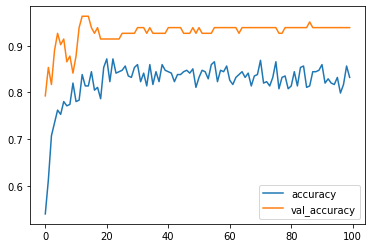

In [63]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

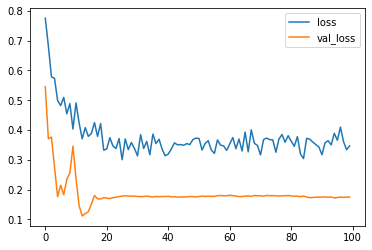

In [64]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

## prediction

In [65]:
model.load_weights("weights.best.hdf5")

In [66]:
Y_val_pred = model.predict(x_val)

In [67]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9634146341463414

In [68]:
Y_pred = model.predict(X_test)

In [69]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\joych\anaconda3\envs\image\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
100%|██████████| 10/10 [00:53<00:00,  5.39s/it]


## confusion matrix

Confusion matrix, without normalization
[[203   2]
 [106  99]]


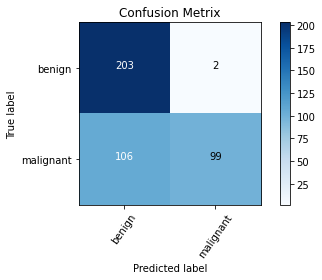

In [70]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix')

Confusion matrix, without normalization
[[204   1]
 [135  70]]


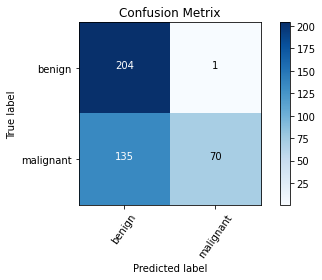

In [71]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix')

## classification report

In [72]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       205
           1       0.99      0.34      0.51       205

    accuracy                           0.67       410
   macro avg       0.79      0.67      0.63       410
weighted avg       0.79      0.67      0.63       410



## ROC and AUC

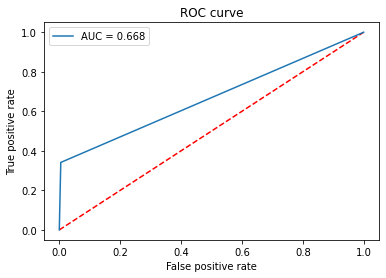

In [73]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

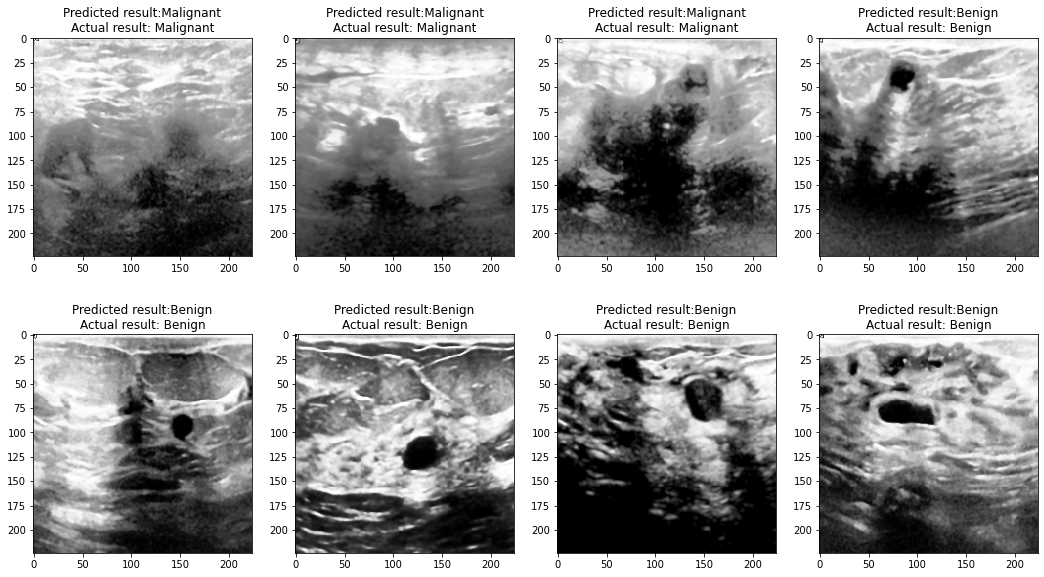

In [74]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()